In [1]:
%load_ext watermark
%watermark -u -d -p numpy,matplotlib,tensorflow,sklearn

Last updated: 2021-06-09

numpy     : 1.19.5
matplotlib: 3.3.4
tensorflow: 2.4.1
sklearn   : 0.24.2



In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

In [3]:
# Data 폴더를 지정한다
DATADIR = 'Data'
CATEGORIES = ['Empty','NotEmpty']

In [4]:
data = []
labels = []

In [5]:
# 학습을 위한 Data를 생성한다 (Gray 변환 및 Resizing 처리)
# Categories의 인덱스를 이용해 간단히 label을 One-hot encoding 처리를 해준다
# 수집된 Image data 중 깨진 data 등 문제가 있는 file은 Data 생성 중 예외처리해서 제외한다

IMG_SIZE = 70

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except:
                print(img)
                pass

create_training_data()

In [6]:
# 생성된 Data를 랜덤 처리해 준다
random.shuffle(training_data)

In [7]:
# 학습을 위해 Feature와 label 데이터를 분리한다

data = []
labels = []

for features, label in training_data:
    data.append(features)
    labels.append(label)

In [8]:
# Tensor 연산이 가능하도록 변경하면서, Feature Data의 차원을 맞춰준다
data = np.array(data, dtype="float32").reshape(-1, IMG_SIZE, IMG_SIZE, 1)
labels = np.array(labels)

In [9]:
# 흑백 영상은 각 픽셀의 값이 0~255이다, 단순히 255.0 나누어 주는 것만으로도 데이터값을 0~1사이로 정규화 가능하다
data = data / 255.0

In [10]:
# training과 testing 데이터로 80:20 수준으로 배분한다
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size = 0.20, 
                                                  stratify = labels, 
                                                  random_state = 42)

In [11]:
# 학습을 위한 모델을 만든다
# 두개의 선택지가 있는 분류 모델이기 때문에 종단의 activation은 sigmoid함수를, 손실함수는 binary_crossentropy를 사용한다
# Data가 많지 않기에 과적합을 예방하기 위해 layer를 최대한 단순히 구상했다

def build_model():
    model = Sequential()
    
    model.add(Conv2D(64, (3,3), activation='relu', input_shape = trainX.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # model.add(Conv2D(64, (3,3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Flatten층을 추가하여 출력을 1차원으로 변환한다
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    
    # 과적합을 막기위해 Dropout을 적용한다
    model.add(Dropout(0.5))
    
    # 가중치 학습을 위해 Dense 레이어를 추가한다
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(lr = INIT_LR, decay = INIT_LR / EPOCHS)
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
    
    return model

In [12]:
# 학습 환경 변수 설정, Epoch 및 batch_size를 바꿔가며 튜닝해 본다

INIT_LR = 1e-4
# EPOCHS = 15
EPOCHS = 80
# BATCH_SIZE = 20
BATCH_SIZE = 16

In [13]:
# Keras에서 제공하는 Image Data Generator를 사용하여 부족한 데이터를 늘려준다
aug = ImageDataGenerator(rotation_range = 20,
                         zoom_range = 0.15,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         shear_range = 0.15,
                         horizontal_flip = True,
                         fill_mode = "nearest")

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1048640   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

## Holdout method

In [16]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size = BATCH_SIZE),
    # steps_per_epoch = len(trainX) // BATCH_SIZE,
    validation_data = (testX, testY),
    # validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS, 
    verbose=1)

Epoch 1/80
9/9 [==============================] - 2s 136ms/step - loss: 0.6548 - accuracy: 0.5986 - val_loss: 0.5446 - val_accuracy: 0.7714
Epoch 2/80
9/9 [==============================] - 0s 48ms/step - loss: 0.5793 - accuracy: 0.7436 - val_loss: 0.5402 - val_accuracy: 0.7714
Epoch 3/80
9/9 [==============================] - 0s 47ms/step - loss: 0.5894 - accuracy: 0.7221 - val_loss: 0.5218 - val_accuracy: 0.7714
Epoch 4/80
9/9 [==============================] - 0s 48ms/step - loss: 0.5803 - accuracy: 0.7449 - val_loss: 0.5078 - val_accuracy: 0.7714
Epoch 5/80
9/9 [==============================] - 0s 48ms/step - loss: 0.5383 - accuracy: 0.7825 - val_loss: 0.4931 - val_accuracy: 0.7714
Epoch 6/80
9/9 [==============================] - 0s 48ms/step - loss: 0.5766 - accuracy: 0.7406 - val_loss: 0.4804 - val_accuracy: 0.7714
Epoch 7/80
9/9 [==============================] - 0s 48ms/step - loss: 0.5571 - accuracy: 0.7332 - val_loss: 0.4581 - val_accuracy: 0.7714
Epoch 8/80
9/9 [==========

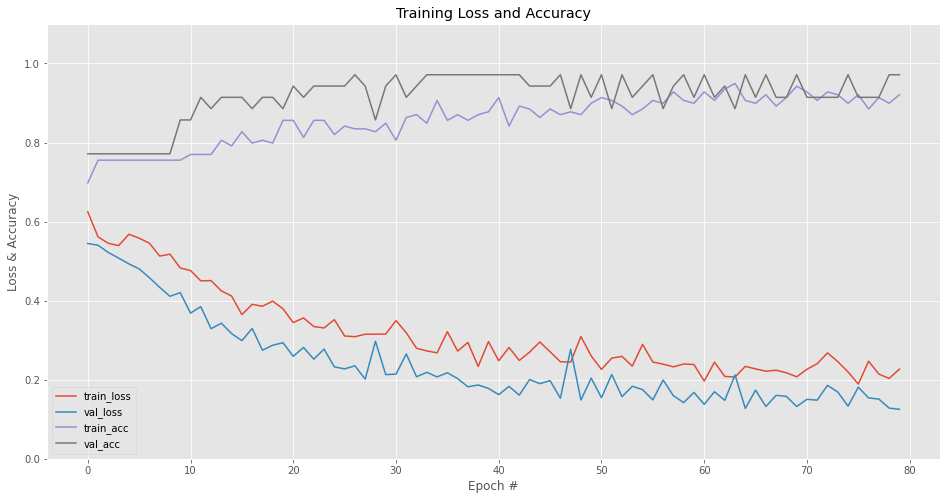

In [17]:
# training loss와 accuracy 그래프를 출력해 학습 결과를 확인한다

plt.rcParams["figure.figsize"] = (16,8)
plt.style.use("ggplot")
plt.figure()
plt.ylim([0, 1.1])
plt.plot(H.history["loss"], label = "train_loss")
plt.plot(H.history["val_loss"], label = "val_loss")
plt.plot(H.history["accuracy"], label = "train_acc")
plt.plot(H.history["val_accuracy"], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss & Accuracy")
plt.legend(loc = "lower left")
plt.savefig("Training_result_Holdout")

In [18]:
# 학습 결과를 저장한다
model.save("empty_v2_Holdout.model", save_format = "h5")

## K-Fold Cross Validation

In [20]:
# K-Fold Cross Validation을 위해 k값과 validation Sample 크기를 정한다
# K값을 바꿔하며 튜닝해 본다

# k = 6
k = 4
num_val_samples = len(trainX) // k

In [21]:
# 학습하기엔 데이터가 무척 부족하기 위해 최대한 학습 효과를 끌어 올리기 위해 K-Fold Cross Validation을 적용한다

all_loss_histories = []
all_valloss_histories = []
all_acc_histories = []
all_valacc_histories = []

for i in range(k):
    print('처리중인 폴드 #', i+1)
    # 검증 데이터 준비: k번째 분할
    val_data = trainX[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = trainY[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: k번째 분할을 제외한 나머지 데이터
    partial_train_data = np.concatenate(
        [trainX[:i * num_val_samples],
         trainX[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성 (컴파일 포함)
    model = build_model()
    # model.fit(partial_train_data, partial_train_targets,
    #          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    
    H = model.fit(
        aug.flow(partial_train_data, partial_train_targets, batch_size = BATCH_SIZE),
        # steps_per_epoch = len(partial_train_data) // BATCH_SIZE,
        validation_data = (val_data, val_targets),
        # validation_steps = len(val_data) // BATCH_SIZE,
        epochs = EPOCHS,
        # verbose 값을 0으로 설정 학습 중 아무 것도 출력하지 않도록 한다
        verbose=0)
    
    # k-fold Cross Validation 학습결과를 누적한다
    loss_history = H.history["loss"]
    all_loss_histories.append(loss_history)
    
    valloss_history = H.history["val_loss"]
    all_valloss_histories.append(valloss_history)
    
    acc_history = H.history["accuracy"]
    all_acc_histories.append(acc_history)
    
    valacc_history = H.history["val_accuracy"]
    all_valacc_histories.append(valacc_history) 

처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
처리중인 폴드 # 4


In [22]:
# 결과 그패프를 그리기 위해 누적된 학습결과를 Epoch마다 평균처리한다

average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(EPOCHS)]
average_valloss_history = [
    np.mean([x[i] for x in all_valloss_histories]) for i in range(EPOCHS)]
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(EPOCHS)]
average_valacc_history = [
    np.mean([x[i] for x in all_valacc_histories]) for i in range(EPOCHS)]

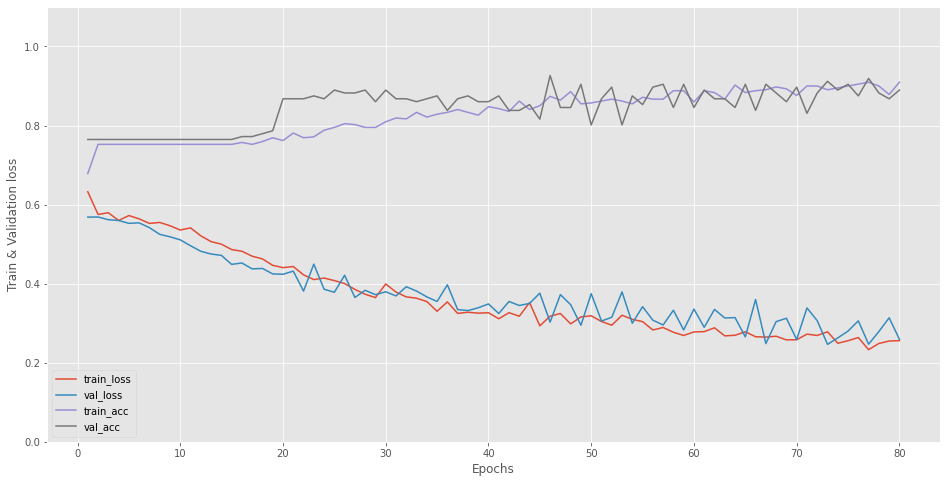

In [23]:
# K-Fold Cross Validation 학습결과를 그래프로 출력한다

plt.ylim([0, 1.1])
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, label = "train_loss")
plt.plot(range(1, len(average_valloss_history) + 1), average_valloss_history, label = "val_loss")
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history, label = "train_acc")
plt.plot(range(1, len(average_valacc_history) + 1), average_valacc_history, label = "val_acc")
plt.xlabel('Epochs')
plt.ylabel('Train & Validation loss')
plt.legend(loc = "lower left")
plt.savefig("Training_result_k-fold")

In [24]:
# serialize the model to disk
model.save("empty_v2_K-Fold.model", save_format = "h5")